In [434]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import tempfile
import statsmodels.api as sm
import os
from tensorflow import keras
import statsmodels.formula.api as smf

from tensorflow.keras import layers
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
import pymssql
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from tqdm import tqdm
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from mpl_toolkits import mplot3d
import yaml
from scipy.stats import pearsonr
import decimal
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier


random_state = 2023

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

server_info = config["server"]

print(config)

2.9.0
{'server': {'name': 'localhost', 'user': 'sa', 'password': 'Passw0rd!', 'database': 'Loans_2023_01_27'}, 'tables': [{'name': 'dbo.UnderwritingData', 'primary': 'VIN', 'secondary': 'CreaditScore', 'null_secondary': 0}, {'name': 'dbo.RawAlgorithmData', 'primary': 'Vin6', 'secondary': 'Score', 'null_secondary': 0}], 'predictions': {'target': 'ProcStatsCd', 'replace': {'CL': 1, 'CO': 0}, 'doSpecial': False, 'special': 'DelqPct'}, 'ignore': ['Class_', 'AccountShort', 'CustomerNumber', 'CurBalAmt', 'Customer', 'AdminStatus', 'NumberPmnt', 'NumberPmnt', 'ResultCD', 'ChargeOffDt', 'PercentageOfPaymentsMade', 'DelqCalcAlert', 'RecyCalcAlert', 'ApplicationNumber', 'CurrentPaymentsMade', 'Name', 'Delq'], 'outliers': {'ignore': ['Status', 'DelqPct', 'CreaditScore', 'HomeOwner', 'Reposessions', 'Chageoff', 'APR']}}


In [418]:
class DatabaseLoader:
    def __init__(self, _server_info):
        _conn = pymssql.connect(server=server_info['name'], user=server_info['user'], password=server_info['password'], database=server_info['database'])

        self._cursor = _conn.cursor()
        self._empty = True
        self.df = None
        self._global_primary = None
        self._global_secondary = None
        self._global_primary_type = None
        self._global_secondary_type = None
        self._target = None
        self._special_target = None

    def get_column_index(self, _column_name):
        for index, col in enumerate(self._cursor.description):
            if col[0] == _column_name:
                return index

    def replace_col_name(self, _cur_headers, _old, _new):
        for idx, header in enumerate(_cur_headers):
            if header==_old:
                _cur_headers[idx] = _new

    def load_table(self, _table_info, ignore=None):
        if ignore is None:
            ignore = []
        self._cursor.execute("SELECT * FROM {table}".format(table=_table_info['name']))

        _headers = []
        _rows = []

        for entity in self._cursor.description:
            _headers.append(entity[0])

        _primary_index = self.get_column_index(_table_info['primary'])
        _secondary_index = self.get_column_index(_table_info['secondary'])

        _res = self._cursor.fetchone()
        while _res:
            _row = [element for element in _res]
            if _row[_primary_index] is not None and _row[_primary_index].strip() != "n/a" and _row[_secondary_index] != _table_info['null_secondary']:
                # Strips trailing whitespace from strings
                for idx, item in enumerate(_row):
                    if isinstance(item, str):
                        _row[idx] = item.strip()

                    if isinstance(item, decimal.Decimal):
                        _row[idx] = float(item)

                _rows.append(_row)
            _res = self._cursor.fetchone()

        if self._empty:
            self._empty = False
            self.df = pd.DataFrame(_rows, columns=_headers)
            self._global_primary = _table_info['primary']
            self._global_secondary = _table_info['secondary']
            self._global_primary_type = type(self.df[self._global_primary].iloc[0])
            self._global_secondary_type = type(self.df[self._global_secondary].iloc[0])
        else:
            # Replace the primary and secondary key column names with the global primary and secondary key names
            self.replace_col_name(_headers, _table_info['primary'], self._global_primary)
            self.replace_col_name(_headers, _table_info['secondary'], self._global_secondary)

            temp_df = pd.DataFrame(_rows, columns = _headers)
            # Cast the primary and secondary keys to global type
            temp_df[self._global_primary] = temp_df[self._global_primary].astype(self._global_primary_type)
            temp_df[self._global_secondary] = temp_df[self._global_secondary].astype(self._global_secondary_type)

            self.df = pd.merge(temp_df, self.df, how = 'inner', on=['VIN', 'CreaditScore'])

        # Remove any columns to ignore
        self.df = self.df.drop(labels = ignore, axis=1, errors='ignore')

    def move_col_to_end(self, col):
        cols = list(self.df.columns)
        cols.remove(col)
        cols.append(col)
        self.df = self.df[cols]

    def prune_for_target(self, _prediction_info):
        self._target = _prediction_info['target']
        _replace_guide = _prediction_info['replace']

        self.df = self.df[self.df[self._target].isin(list(_replace_guide.keys()))]
        for key, value in _replace_guide.items():
            self.df[self._target].replace(to_replace=key, value=value, inplace=True)

        # Move the target to the end of the dataframe
        cols = list(self.df.columns)
        cols.remove(self._target)
        cols.append(self._target)
        self.df = self.df[cols]

        if _prediction_info['doSpecial']:
            if _prediction_info['special'] == 'DelqPct':
                self.df = self.df[self.df['OpeningBalance']!=0]
                self.df['DelqPct'] = self.df.apply(lambda row : (100*row['Delq'])/row['OpeningBalance'],axis=1)

                # Remove the old target and Delq from the dataframe
                cols = list(self.df.columns)
                cols.remove(self._target)
                cols.remove("Delq")
                self.df = self.df[cols]
                self._target = "DelqPct"


    def remove_majority_null(self, threshold = .7):
        total = len(self.df)
        cols_to_drop = []
        percents = []
        for column in self.df.columns:
            non_null_count = 0
            for idx, item in self.df[column].items():
                if item is not None:
                    non_null_count +=1
            percent = float(non_null_count)/float(total)
            if percent < threshold:
                cols_to_drop.append(column)
                percents.append((1-percent)*100)

        self.df = self.df.drop(cols_to_drop, axis = 1)
        for idx, column in enumerate(cols_to_drop):
            print("Dropping {column} since {percent}% of entires were Null".format(column=column, percent = percents[idx]))

    def contains_null_or_is_categorical(self, series):
        if self.is_categorical(series):
            return True

        for idx, item in series.items():
            if item is None:
                return True

        return False

    def get_type_series(self, series):
        for idx, item in series.items():
            if item is not None:
                return type(item)
        return None

    def is_categorical(self, series):
        return self.get_type_series(series) == str

    def get_correlated_entities(self, threshold = 0.1, inplace= False):
        corrs = dict()
        print("Computing Entity Correlations")
        for col in tqdm(self.df.columns):
            if col == self._target or self.contains_null_or_is_categorical(self.df[col]):
                continue
            corr, _ = pearsonr(self.df[col], self.df[self._target])
            corrs[col] = abs(corr)

        corrs = {k: v for k, v in sorted(corrs.items(), key=lambda item: item[1])}

        goodCols = []

        for col, score in corrs.items():
            if score>=threshold:
                goodCols.append(col)

        print(goodCols)

        if inplace:
            goodCols.append(self._target)
            self.df = self.df[goodCols]
        else:
            return self.df[goodCols]

    def remove_outliers(self, lower_thresh = 0.00, upper_thresh = 0.999, ignore=None):
        if ignore is None:
            ignore = []
        for col in self.df.columns:
            if col in ignore or col==self._target or self.is_categorical(self.df[col]):
                continue
            percentiles = self.df[col].quantile([lower_thresh, upper_thresh]).values
            self.df.loc[self.df[col]<=percentiles[0], col] = percentiles[0]
            self.df.loc[self.df[col]>=percentiles[1], col] = percentiles[1]

    def get_target_col(self):
        return self.df[self._target]

    def get_categorical_vars(self):
        cats = []
        for col in self.df.columns:
            if self.is_categorical(self.df[col]):
                cats.append(col)
        return cats

    def one_hot(self, inplace = False):
        cat_attribs = self.get_categorical_vars()
        full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')
        encoder = full_pipeline.fit(self.df)
        if inplace:
            self.df = encoder.transform(self.df)
        else:
            return encoder.transform(self.df)

    def one_hot_dummies(self, inplace=False):
        cat_attribs = self.get_categorical_vars()
        temp_df = self.df.copy(deep=True)
        print("One Hot Encoding")
        for cat in tqdm(cat_attribs):
            one_hot = pd.get_dummies(self.df[cat])
            for i in one_hot.columns:
                new_name = cat+i
                new_name = new_name.replace("[", "")
                new_name = new_name.replace("]", "")
                new_name = new_name.replace("<", "")
                one_hot.rename(columns={i:new_name}, inplace=True)
            temp_df = temp_df.drop(cat, axis=1)
            temp_df = pd.concat([temp_df, one_hot], axis=1)

        if inplace:
            self.df = temp_df
            self.move_col_to_end(self._target)
        else:
            return temp_df

    def get_df_no_categoricals(self):
        return self.df.drop(self.get_categorical_vars(), axis=1)

In [435]:
dbl = DatabaseLoader(server_info)

dbl.load_table(config['tables'][0], ignore=config['ignore'])
dbl.load_table(config['tables'][1], ignore=config['ignore'])
dbl.prune_for_target(config['predictions'])
dbl.remove_majority_null()

dbl.remove_outliers(ignore = config['outliers']['ignore'])

# dbl.one_hot_dummies(True)
# dbl.get_correlated_entities()



Dropping Discount since 100.0% of entires were Null
Dropping CustomScore since 44.51843043995244% of entires were Null
       CreaditScore  Salary_x    Recy  OrigTerm    Apr  OpeningBalance  \
0               676    600.00   490.0        42  20.98         8231.24   
1               532   9026.33   400.0        48  22.99        13048.40   
2               531   2800.00   165.0        48  24.99         8704.21   
3               572   2000.00    70.0        48  22.00        11913.48   
4               513   4533.00   293.0        48  22.95        11375.39   
...             ...       ...     ...       ...    ...             ...   
13140           516   7000.00    18.0        54  18.99        12423.17   
13164           580   3000.00    29.0        46  22.90        11500.00   
13167           566   3640.00    30.0        48  21.90        14700.00   
13212           512   2850.00  1287.0        48  24.90        11500.00   
13213           462   4300.00  1413.0        52  19.90        16001

## Ensemble Filtering

In [483]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

epochs = 10
num_models = 10

filter = dbl.get_df_no_categoricals().copy(deep=True).head(6000)

initIds= [i for i in range(len(filter))]
filter["ID"] = initIds

cols = list(filter.columns)
cols.remove("ProcStatsCd")
cols.append("ProcStatsCd")
filter = filter[cols]


num_removed = 0

for i in range(epochs):
    models = []
    for n in tqdm(range(num_models)):
        x_train, x_test, y_train, y_test = train_test_split(filter.iloc[:,:-2], filter.iloc[:,-1:], test_size=1.0-(1.0/num_models))

        # Instantiate model with 1000 decision trees
        rf = RandomForestClassifier(n_estimators = 10)
        # Train the model on training data
        rf.fit(x_train.values, y_train.values)

        models.append(rf)

    for idx, row in filter.iterrows():
        curId = row["ID"]
        dp = row.iloc[:-2]
        y = int(row.iloc[-1:]['ProcStatsCd'])
        correct = 0
        for model in models:
            pred = model.predict(dp.values.reshape(1, -1))
            if pred[0]==y:
                correct +=1

        if correct<(num_models/2):
            #Remove this data point from the training set
            filter = filter[filter["ID"]!=curId]
            print("Removing {id}".format(id=curId))
            num_removed+=1
print(filter)



100%|██████████| 10/10 [00:00<00:00, 83.76it/s]


Removing 2.0
Removing 3.0
Removing 6.0
Removing 9.0
Removing 10.0
Removing 11.0
Removing 12.0
Removing 15.0
Removing 20.0
Removing 21.0
Removing 22.0
Removing 24.0
Removing 25.0
Removing 26.0
Removing 38.0
Removing 39.0
Removing 40.0
Removing 41.0
Removing 42.0
Removing 44.0
Removing 51.0
Removing 55.0
Removing 63.0
Removing 65.0
Removing 74.0
Removing 75.0
Removing 77.0
Removing 84.0
Removing 96.0
Removing 101.0
Removing 104.0
Removing 107.0
Removing 110.0
Removing 112.0
Removing 113.0
Removing 115.0
Removing 119.0
Removing 121.0
Removing 127.0
Removing 128.0
Removing 130.0
Removing 132.0
Removing 134.0
Removing 135.0
Removing 139.0
Removing 141.0
Removing 151.0
Removing 152.0
Removing 155.0
Removing 158.0
Removing 159.0
Removing 160.0
Removing 164.0
Removing 166.0
Removing 170.0
Removing 171.0
Removing 174.0
Removing 175.0
Removing 185.0
Removing 187.0
Removing 189.0
Removing 194.0
Removing 196.0
Removing 204.0
Removing 208.0
Removing 212.0
Removing 216.0
Removing 224.0
Removing 230.

100%|██████████| 10/10 [00:00<00:00, 116.98it/s]


Removing 23.0
Removing 73.0
Removing 81.0
Removing 103.0
Removing 114.0
Removing 117.0
Removing 145.0
Removing 146.0
Removing 156.0
Removing 157.0
Removing 163.0
Removing 183.0
Removing 184.0
Removing 201.0
Removing 206.0
Removing 211.0
Removing 214.0
Removing 222.0
Removing 235.0
Removing 241.0
Removing 250.0
Removing 256.0
Removing 267.0
Removing 269.0
Removing 274.0
Removing 284.0
Removing 289.0
Removing 295.0
Removing 297.0
Removing 310.0
Removing 326.0
Removing 327.0
Removing 341.0
Removing 342.0
Removing 363.0
Removing 366.0
Removing 380.0
Removing 396.0
Removing 398.0
Removing 416.0
Removing 420.0
Removing 430.0
Removing 434.0
Removing 435.0
Removing 436.0
Removing 442.0
Removing 444.0
Removing 447.0
Removing 448.0
Removing 450.0
Removing 463.0
Removing 464.0
Removing 473.0
Removing 478.0
Removing 481.0
Removing 486.0
Removing 494.0
Removing 496.0
Removing 499.0
Removing 514.0
Removing 526.0
Removing 527.0
Removing 535.0
Removing 537.0
Removing 547.0
Removing 557.0
Removing 558.

100%|██████████| 10/10 [00:00<00:00, 118.06it/s]


Removing 28.0
Removing 83.0
Removing 98.0
Removing 99.0
Removing 133.0
Removing 168.0
Removing 193.0
Removing 227.0
Removing 236.0
Removing 254.0
Removing 303.0
Removing 304.0
Removing 352.0
Removing 376.0
Removing 381.0
Removing 388.0
Removing 389.0
Removing 401.0
Removing 402.0
Removing 409.0
Removing 449.0
Removing 452.0
Removing 550.0
Removing 684.0
Removing 690.0
Removing 746.0
Removing 751.0
Removing 776.0
Removing 801.0
Removing 821.0
Removing 839.0
Removing 869.0
Removing 870.0
Removing 891.0
Removing 908.0
Removing 912.0
Removing 922.0
Removing 923.0
Removing 928.0
Removing 980.0
Removing 989.0
Removing 1003.0
Removing 1071.0
Removing 1075.0
Removing 1077.0
Removing 1078.0
Removing 1107.0
Removing 1113.0
Removing 1120.0
Removing 1130.0
Removing 1131.0
Removing 1151.0
Removing 1181.0
Removing 1183.0
Removing 1197.0
Removing 1205.0
Removing 1226.0
Removing 1244.0
Removing 1249.0
Removing 1257.0
Removing 1290.0
Removing 1322.0
Removing 1350.0
Removing 1383.0
Removing 1386.0
Remov

100%|██████████| 10/10 [00:00<00:00, 130.89it/s]

Removing 16.0


Removing 111.0
Removing 138.0
Removing 231.0
Removing 237.0
Removing 268.0
Removing 371.0
Removing 421.0
Removing 438.0
Removing 471.0
Removing 574.0
Removing 576.0
Removing 581.0
Removing 632.0
Removing 644.0
Removing 668.0
Removing 731.0
Removing 771.0
Removing 797.0
Removing 916.0
Removing 997.0
Removing 1026.0
Removing 1057.0
Removing 1060.0
Removing 1132.0
Removing 1153.0
Removing 1201.0
Removing 1275.0
Removing 1282.0
Removing 1303.0
Removing 1312.0
Removing 1330.0
Removing 1369.0
Removing 1445.0
Removing 1455.0
Removing 1465.0
Removing 1503.0
Removing 1522.0
Removing 1530.0
Removing 1535.0
Removing 1578.0
Removing 1581.0
Removing 1610.0
Removing 1686.0
Removing 1697.0
Removing 1846.0
Removing 1858.0
Removing 1935.0
Removing 1943.0
Removing 1950.0
Removing 1972.0
Removing 2050.0
Removing 2064.0
Removing 2116.0
Removing 2160.0
Removing 2190.0
Removing 2216.0
Removing 2233.0
Removing 2289.0
Removing 2296.0
Removing 2303.0
Removing 2356.0
Removing 2434.0
Removing 2436.0
Removing 245

100%|██████████| 10/10 [00:00<00:00, 141.98it/s]

Removing 35.0


Removing 56.0
Removing 57.0
Removing 71.0
Removing 97.0
Removing 161.0
Removing 221.0
Removing 229.0
Removing 313.0
Removing 350.0
Removing 413.0
Removing 446.0
Removing 466.0
Removing 498.0
Removing 525.0
Removing 536.0
Removing 546.0
Removing 551.0
Removing 564.0
Removing 652.0
Removing 662.0
Removing 669.0
Removing 679.0
Removing 721.0
Removing 735.0
Removing 837.0
Removing 931.0
Removing 959.0
Removing 969.0
Removing 1024.0
Removing 1064.0
Removing 1089.0
Removing 1104.0
Removing 1129.0
Removing 1170.0
Removing 1179.0
Removing 1241.0
Removing 1334.0
Removing 1429.0
Removing 1479.0
Removing 1494.0
Removing 1543.0
Removing 1596.0
Removing 1597.0
Removing 1623.0
Removing 1645.0
Removing 1661.0
Removing 1767.0
Removing 1770.0
Removing 1779.0
Removing 1814.0
Removing 1821.0
Removing 1882.0
Removing 1898.0
Removing 1951.0
Removing 1964.0
Removing 1975.0
Removing 2039.0
Removing 2075.0
Removing 2126.0
Removing 2137.0
Removing 2163.0
Removing 2192.0
Removing 2234.0
Removing 2262.0
Removing

100%|██████████| 10/10 [00:00<00:00, 143.91it/s]


Removing 13.0
Removing 46.0
Removing 70.0
Removing 108.0
Removing 177.0
Removing 334.0
Removing 497.0
Removing 596.0
Removing 664.0
Removing 676.0
Removing 783.0
Removing 872.0
Removing 946.0
Removing 951.0
Removing 1242.0
Removing 1291.0
Removing 1295.0
Removing 1368.0
Removing 1467.0
Removing 1646.0
Removing 1674.0
Removing 1737.0
Removing 1938.0
Removing 2024.0
Removing 2057.0
Removing 2062.0
Removing 2089.0
Removing 2105.0
Removing 2202.0
Removing 2248.0
Removing 2310.0
Removing 2513.0
Removing 2524.0
Removing 2619.0
Removing 2622.0
Removing 2648.0
Removing 2677.0
Removing 2691.0
Removing 2817.0
Removing 2833.0
Removing 2880.0
Removing 2907.0
Removing 2958.0
Removing 2997.0
Removing 3016.0
Removing 3039.0
Removing 3160.0
Removing 3195.0
Removing 3213.0
Removing 3324.0
Removing 3369.0
Removing 3507.0
Removing 3526.0
Removing 3546.0
Removing 3609.0
Removing 3633.0
Removing 3653.0
Removing 3688.0
Removing 3722.0
Removing 3751.0
Removing 3792.0
Removing 3833.0
Removing 3938.0
Removing 

100%|██████████| 10/10 [00:00<00:00, 129.77it/s]


Removing 215.0
Removing 283.0
Removing 329.0
Removing 391.0
Removing 490.0
Removing 800.0
Removing 825.0
Removing 1091.0
Removing 1280.0
Removing 1316.0
Removing 1422.0
Removing 1580.0
Removing 1603.0
Removing 1834.0
Removing 1876.0
Removing 1956.0
Removing 2054.0
Removing 2200.0
Removing 2203.0
Removing 2209.0
Removing 2561.0
Removing 2685.0
Removing 2760.0
Removing 3178.0
Removing 3273.0
Removing 3483.0
Removing 3541.0
Removing 3566.0
Removing 4075.0
Removing 4124.0
Removing 4128.0
Removing 4192.0
Removing 4228.0
Removing 4325.0
Removing 4452.0
Removing 4521.0
Removing 4608.0
Removing 4803.0
Removing 4822.0
Removing 4900.0
Removing 5120.0
Removing 5133.0
Removing 5135.0
Removing 5394.0
Removing 5430.0
Removing 5436.0
Removing 5524.0
Removing 5566.0
Removing 5654.0
Removing 5665.0
Removing 5770.0
Removing 5800.0
Removing 5811.0


100%|██████████| 10/10 [00:00<00:00, 139.56it/s]


Removing 95.0
Removing 100.0
Removing 192.0
Removing 275.0
Removing 321.0
Removing 382.0
Removing 410.0
Removing 470.0
Removing 475.0
Removing 579.0
Removing 601.0
Removing 630.0
Removing 756.0
Removing 871.0
Removing 880.0
Removing 963.0
Removing 1062.0
Removing 1076.0
Removing 1103.0
Removing 1311.0
Removing 1337.0
Removing 1341.0
Removing 1364.0
Removing 1397.0
Removing 1443.0
Removing 1540.0
Removing 1567.0
Removing 1613.0
Removing 1633.0
Removing 1649.0
Removing 1678.0
Removing 1819.0
Removing 1824.0
Removing 1831.0
Removing 1922.0
Removing 2060.0
Removing 2145.0
Removing 2274.0
Removing 2369.0
Removing 2401.0
Removing 2413.0
Removing 2478.0
Removing 2586.0
Removing 2741.0
Removing 2819.0
Removing 2954.0
Removing 3001.0
Removing 3100.0
Removing 3135.0
Removing 3172.0
Removing 3639.0
Removing 3649.0
Removing 3670.0
Removing 3828.0
Removing 3864.0
Removing 3866.0
Removing 3941.0
Removing 4485.0
Removing 4551.0
Removing 4652.0
Removing 5238.0
Removing 5711.0
Removing 5720.0
Removing 

100%|██████████| 10/10 [00:00<00:00, 138.55it/s]


Removing 87.0
Removing 262.0
Removing 278.0
Removing 354.0
Removing 480.0
Removing 506.0
Removing 753.0
Removing 793.0
Removing 936.0
Removing 964.0
Removing 1430.0
Removing 1836.0
Removing 1923.0
Removing 1931.0
Removing 1959.0
Removing 1996.0
Removing 2225.0
Removing 2372.0
Removing 2398.0
Removing 2463.0
Removing 2521.0
Removing 2641.0
Removing 2695.0
Removing 2735.0
Removing 2798.0
Removing 2937.0
Removing 3008.0
Removing 3022.0
Removing 3071.0
Removing 3073.0
Removing 3271.0
Removing 3315.0
Removing 3336.0
Removing 3425.0
Removing 3509.0
Removing 3563.0
Removing 3717.0
Removing 3876.0
Removing 3943.0
Removing 4005.0
Removing 4048.0
Removing 4120.0
Removing 4242.0
Removing 4255.0
Removing 4297.0
Removing 4309.0
Removing 4346.0
Removing 4361.0
Removing 4418.0
Removing 4460.0
Removing 4742.0
Removing 4764.0
Removing 4858.0
Removing 5016.0
Removing 5027.0
Removing 5102.0
Removing 5114.0
Removing 5220.0
Removing 5253.0
Removing 5264.0
Removing 5325.0
Removing 5369.0
Removing 5559.0
Rem

100%|██████████| 10/10 [00:00<00:00, 133.15it/s]


Removing 167.0
Removing 180.0
Removing 415.0
Removing 428.0
Removing 534.0
Removing 757.0
Removing 917.0
Removing 999.0
Removing 1589.0
Removing 1600.0
Removing 1755.0
Removing 1985.0
Removing 2027.0
Removing 2254.0
Removing 2433.0
Removing 2453.0
Removing 2491.0
Removing 2536.0
Removing 2576.0
Removing 2626.0
Removing 2652.0
Removing 2662.0
Removing 2762.0
Removing 2962.0
Removing 3013.0
Removing 3295.0
Removing 3366.0
Removing 3409.0
Removing 3487.0
Removing 3523.0
Removing 3592.0
Removing 3624.0
Removing 3647.0
Removing 3661.0
Removing 3782.0
Removing 3840.0
Removing 3886.0
Removing 3923.0
Removing 3971.0
Removing 4004.0
Removing 4211.0
Removing 4405.0
Removing 4451.0
Removing 4574.0
Removing 4711.0
Removing 4845.0
Removing 4893.0
Removing 5250.0
Removing 5380.0
Removing 5756.0
Removing 5894.0
      CreaditScore  Salary_x    Recy  OrigTerm    Apr  OpeningBalance  \
0              676    600.00   490.0        42  20.98         8231.24   
1              532   9026.33   400.0        48

[0 1 0 0 1 0 1 0 0 0]
    ProcStatsCd
0             1
1             1
4             1
5             0
8             1
9             0
15            0
18            0
19            1
20            0
       CreaditScore  Salary_x    Recy  OrigTerm    Apr  OpeningBalance  \
10003           467    2400.0   587.0        32  24.00         7773.89   
10004           540    8000.0   412.0        48  24.00        12028.24   
10005           513       0.0   110.0        48  24.90        13995.00   
10007           610    3000.0   657.0        42  24.00         9503.21   
10009           510    3960.0   184.0        54  18.00        10046.99   
...             ...       ...     ...       ...    ...             ...   
13140           516    7000.0    18.0        54  18.99        12423.17   
13164           580    3000.0    29.0        46  22.90        11500.00   
13167           566    3640.0    30.0        48  21.90        14700.00   
13212           512    2850.0  1287.0        48  24.90        

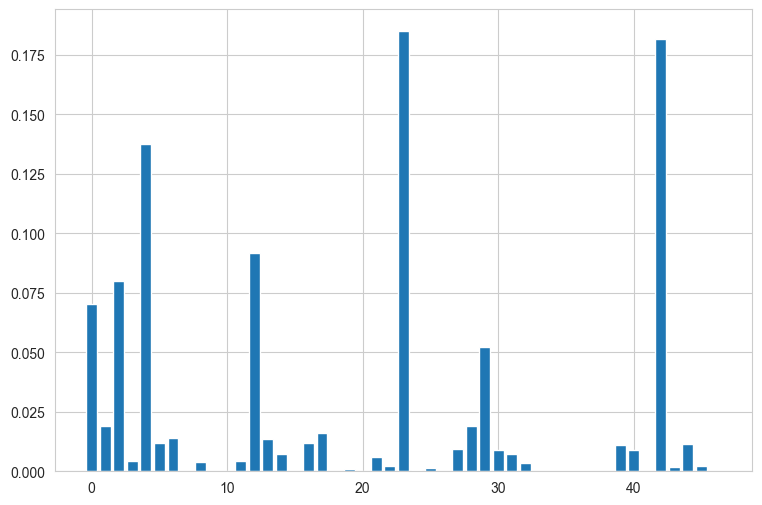

In [484]:
test = dbl.get_df_no_categoricals().copy(deep=True).tail(2000)
testX = test.iloc[:,:-1]
testy = test.iloc[:,-1:]

#has to be -2 since filter has an ID
trainX = filter.iloc[:,:-2]
trainy = filter.iloc[:,-1:]

rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(trainX, trainy)

preds = rf.predict(testX)

print(preds[:10])
print(trainy[:10])
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from matplotlib import pyplot

print(testX)

print(confusion_matrix(testy, preds))
# Display accuracy score
print(accuracy_score(testy, preds))
# Display F1 score
print(f1_score(testy,preds))

importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## XGBoost

In [410]:
xgdata = dbl.df.copy(deep=True)

accs = []
for x in tqdm(range(3)):
    x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)

    train = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
    test = xgb.DMatrix(x_test, label=y_test, enable_categorical=True)

    param = {
        'eta': 0.01,
        'objective': 'reg:squarederror',
    }
    epochs = 500

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)

    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(metrics.mean_squared_error(y_test, y, squared=False), 3)
    # model.save_model('Models/Delq/XGBoost_{}%_Scorelate.json'.format(acc))

    print("Acc: ", end='')
    print(acc)

    accs.append(acc)

    pred = model.predict(xgb.DMatrix(x_test))
    print("Preds")
    print(pred[:10])
    print("Test")
    print(y_test[:10])

print(sum(accs)/len(accs))

  0%|          | 0/3 [04:44<?, ?it/s]


KeyboardInterrupt: 

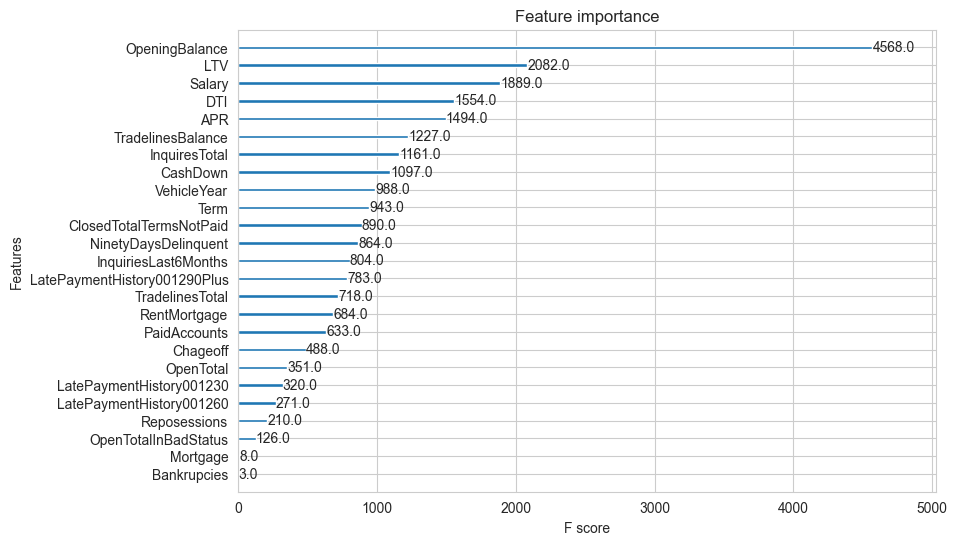

In [180]:
xgb_ml = xgb.Booster()

xgb_ml.load_model('Models/Delq/XGBoost_6.765%_Scorelate.json')
# x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2)
# print(xgb_ml.predict(xgb.DMatrix(x_test[:5])))
# print(y_test[:5])

# plot feature importance
plot_importance(xgb_ml)
plt.show()

In [365]:
res = xgb_ml.predict(xgb.DMatrix(x_test))
preds = []
actual = []
for pred in res:
    if(pred<3.5):
        preds.append("Paid")
    else:
        preds.append("CO")

for result in y_test["DelqPct"]:
    if result == 0.0:
        actual.append("Paid")
    else:
        actual.append("CO")

paidandpredpaid = 0
paidandpredco = 0
coandpredpaid = 0
coandpredco = 0

avgPaid = []
avgCO = []

for i in range(len(preds)):
    if preds[i]=="Paid" and actual[i]=="Paid":
        paidandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="Paid":
        paidandpredco+=1
    elif preds[i]=="Paid" and actual[i]=="CO":
        coandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="CO":
        coandpredco+=1
    if(actual[i]=="Paid"):
        avgPaid.append(res[i])
    else:
        avgCO.append(res[i])

print("Paid and Pred Paid: ", paidandpredpaid)
print("Paid and Pred CO: ", paidandpredco)
print("CO and Pred Paid: ", coandpredpaid)
print("CO and Pred CO: ", coandpredco)

print("Avg Paid: ", sum(avgPaid)/len(avgPaid))
print("Avg CO: ", sum(avgCO)/len(avgCO))

NameError: name 'xgb_ml' is not defined